# ENS Data Challenge
# Who Are The High-frequency Traders?
## Autorité des marchés financiers
### Pierre-Antoine BANNIER – Hubert DE PARSEVAL – Elias LINDBERGS

## Motivation

The goal of this challenge is to classify traders as NON HFT, MIX and HFT for regulatory purposes.

We are provided with quantitative and categorical features related the trading activity of these market participants.


Let's start by importing the python libraries used in our solution.

In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

## Data Pre-processing

We start by ordinal encoding the categorical features **Share** and **Type**.

We then engineer some meta-features.

For every **Trader** and each **Day**, we count the number of **NaN** values for each column.

Additionally, for every **Trader** and each **Day**, we count the number of trades and shares traded. We also count the number of days traded for each **Trader**.

In [2]:
def feature_engineering(df):
    df.Day = df.Day.apply(lambda x: int(x.split('_')[1]))
    df.Share = df.Share.apply(lambda x: int(x.split('_')[1]))
    
    ''''''
    
    df['n_days'] = 0

    df['n_trades'] = 0
    df['n_trades_daily'] = 0

    df['n_shares'] = 0
    df['n_shares_daily'] = 0

    nan_columns = df.columns[df.isna().any()]
    df['n_nans_' + nan_columns] = 0
    df['n_nans_' + nan_columns + '_daily'] = 0

    ''''''

    for trader in tqdm(df.Trader.unique()):
        trader_rows = df[df.Trader == trader]

        df.n_trades[trader_rows.index] = len(trader_rows)
        df.n_days[trader_rows.index] = trader_rows.Day.nunique()
        df.n_shares[trader_rows.index] = trader_rows.Share.nunique()

        for column in nan_columns:
            df['n_nans_' + column][trader_rows.index] = df[column][trader_rows.index].isna().sum()

        for day in trader_rows.Day.unique():
            day_rows = trader_rows[trader_rows.Day == day]

            df.n_trades_daily[trader_rows.index] = len(day_rows)
            df.n_shares_daily[trader_rows.index] = day_rows.Share.nunique()

            df['n_nans_' + column + '_daily'][day_rows.index] = trader_rows[column][day_rows.index].isna().sum()
        
    return df

We then group our meta-features in two clusters to avoid overfitting.

In [3]:
def clustering(x_train, x_test):
    n_clusters = 2
    
    columns = list(x_train)[38:]
    
    for column in tqdm(columns):
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        x_train[column] = kmeans.fit_transform(np.expand_dims(x_train[column], 1)).argmax(1)
        x_test[column] = kmeans.transform(np.expand_dims(x_test[column], 1)).argmax(1)
    
    return x_train, x_test

Finally, we remove some features **mean_dt_TV1_TV4** and **med_dt_TV1_TV4**.

We used backward recursive feature selection to decide leaves these out.

In [4]:
def preprocessor():
    x_train = pd.read_csv('../input/x-train-csv/x_train.csv').drop(columns='Index')
    x_test = pd.read_csv('../input/x-test-csv/x_test.csv').drop(columns='Index')

    x_train = feature_engineering(x_train)
    x_test = feature_engineering(x_test)
    
    x_train, x_test = clustering(x_train, x_test)

    ''''''

    y_train = pd.read_csv('../input/y-train-csv/y_train.csv')
    y_train.type = y_train.type.apply(lambda x: sorted(y_train.type.unique()).index(x))

    ''''''

    for trader in tqdm(x_train.Trader.unique()):
        x_train.Trader.replace(trader, y_train[y_train.Trader == trader].type.values[0], inplace=True)
    
    ''''''
    
    x_train = x_train.T.drop_duplicates().T
    x_train = x_train[x_train.columns[x_train.nunique() > 1]]
    
    x_test = x_test[list(x_train)]
    
    x_train = shuffle(x_train, random_state=0)
    x_train.reset_index(drop=True, inplace=True)
    
    ''''''
    
    y_train = x_train['Trader'].values
    
    columns_to_drop = ['mean_dt_TV1_TV4', 'med_dt_TV1_TV4']
    
    x_train.drop(columns=['Trader'] + columns_to_drop, inplace=True)
    x_test.drop(columns=columns_to_drop, inplace=True)
        
    return x_train, y_train, x_test

### Modeling

We use lightgbm's gradient boosting framework for our classifier.

We employed a stratified 5-fold cross-validation strategy to avoid class imbalance.

We further calibrate our trained models using CalibratedClassifierCV and isotonic regression, which performs better than sigmoid and is robust for large sample sizes.

In [5]:
def cross_validator():
    classifiers = []
    
    y_true = np.array([])
    y_pred = np.array([])
    
    feature_importances = pd.DataFrame(x_train.columns, columns=['feature'])
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    i = 1
    
    for train_indices, test_indices in tqdm(skf.split(x_train, y_train)):
        clf = LGBMClassifier(n_estimators=1000, class_weight='balanced', random_state=0, force_col_wise=True)
        
        clf.fit(
            x_train.iloc[train_indices, :], y_train[train_indices],
            eval_set=(x_train.iloc[test_indices, :], y_train[test_indices]),
            early_stopping_rounds=10,
            verbose=0
        )
        
        feature_importance = pd.DataFrame(sorted(zip(clf.feature_importances_, x_train.columns)), columns=[f'importance_fold_{i}', 'feature'])
        feature_importances = feature_importances.merge(feature_importance, on='feature')
        
        ''''''
        
        clf = CalibratedClassifierCV(base_estimator=clf, cv='prefit')
        clf.fit(x_train.iloc[test_indices, :], y_train[test_indices])
        
        classifiers.append(clf)

        ''''''

        y_true = np.concatenate((y_true, y_train[test_indices]))
        y_pred = np.concatenate((y_pred, clf.predict(x_train.iloc[test_indices, :])))
        
        i = i + 1
    
    ''''''
    
    feature_importances['importance'] = np.mean(feature_importances.filter(regex='importance'), 1)
    feature_importances = feature_importances[['feature', 'importance']].sort_values(by='importance', ascending=False)
    
    return classifiers, feature_importances, y_true, y_pred

In [6]:
x_train, y_train, x_test = preprocessor()
classifiers, feature_importances, y_true, y_pred = cross_validator()

100%|██████████| 86/86 [00:04<00:00, 21.29it/s]
5it [00:52, 10.48s/it]


Our cross-validated f1-score is 0.996057930460759.

Below, we print our confusion matrix and plot feature importance.

f1-score: 0.996057930460759
[[31851    67    32]
 [   43 51221   219]
 [   17    39 22293]]


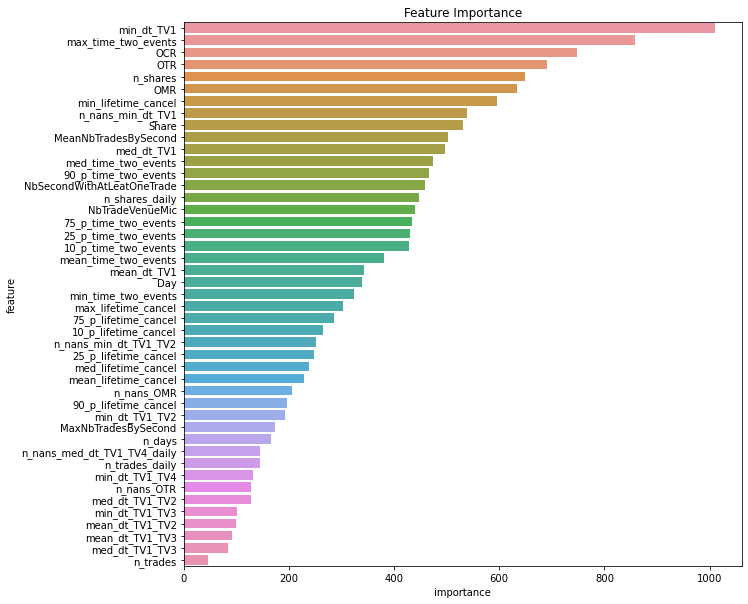

In [7]:
print(f'f1-score: {f1_score(y_true, y_pred, average="micro")}')
print(confusion_matrix(y_true, y_pred))

plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importance');

### Pseudo-labelling

We further use pseudo-labelling to expand our training set.

This method has been shown to improve model performance. We find that a threshold of 0.95 performs best in this challenge.

In [8]:
def pseudo_labeller(x_train, y_train):    
    predictions = np.mean([classifier.predict_proba(x_test.drop(columns='Trader')) for classifier in classifiers], 0)
    high_probability_rows = ((predictions > 0.95).sum(1) == 1)
    
    pseudo_x_train = x_test[high_probability_rows].drop(columns='Trader')
    pseudo_y_train = predictions.argmax(1)[high_probability_rows]
    
    ''''''

    pseudo_x_train = pd.concat((x_train, pseudo_x_train))
    pseudo_y_train = np.concatenate((y_train, pseudo_y_train))
    
    pseudo_x_train, pseudo_y_train = shuffle(pseudo_x_train, pseudo_y_train, random_state=0)
    pseudo_x_train.reset_index(drop=True, inplace=True)
    
    return pseudo_x_train, pseudo_y_train

In [9]:
def pseudo_cross_validator():
    classifiers = []
    
    y_true = np.array([])
    y_pred = np.array([])
    
    feature_importances = pd.DataFrame(x_train.columns, columns=['feature'])
    
    ''''''
    
    train_indices = []
    test_indices = []

    pseudo_test_indices = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    for i, j in skf.split(x_train, y_train):
        train_indices.append(i)
        test_indices.append(j)

    for i, j in skf.split(pseudo_x_train, pseudo_y_train):
        pseudo_test_indices.append(j)
        
    ''''''

    for i in tqdm(range(5)):
        x_train_fold = pd.concat((x_train.iloc[train_indices[i]], pseudo_x_train.iloc[pseudo_test_indices[i]]))
        y_train_fold = np.append(y_train[train_indices[i]], pseudo_y_train[pseudo_test_indices[i]])

        x_train_fold, y_train_fold = shuffle(x_train_fold, y_train_fold, random_state=0)
        x_train_fold.reset_index(drop=True, inplace=True)

        x_test_fold = x_train.iloc[test_indices[i]]
        y_test_fold = y_train[test_indices[i]]
        
        ''''''

        clf = LGBMClassifier(n_estimators=1000, class_weight='balanced', reg_lambda=0.8, random_state=0, force_col_wise=True)

        clf.fit(
            x_train_fold, y_train_fold,
            eval_set=(x_test_fold, y_test_fold),
            early_stopping_rounds=10,
            verbose=0
        )
        
        ''''''
        
        clf = CalibratedClassifierCV(base_estimator=clf, cv='prefit')
        clf.fit(x_test_fold, y_test_fold)
        
        classifiers.append(clf)

        ''''''

        y_true = np.concatenate((y_true, y_test_fold))
        y_pred = np.concatenate((y_pred, clf.predict(x_test_fold)))
    
    return classifiers, y_true, y_pred

In [10]:
pseudo_x_train, pseudo_y_train = pseudo_labeller(x_train, y_train)
classifiers, y_true, y_pred = pseudo_cross_validator()

100%|██████████| 5/5 [01:18<00:00, 15.74s/it]


Our f1-score improved from 0.996057930460759 to 0.9970599913028682.

Moreover, our confusion matrix does not present signs of bias introduced by pseudo-labelling.

In [11]:
print(f'f1-score: {f1_score(y_true, y_pred, average="micro")}')
print(confusion_matrix(y_true, y_pred))

f1-score: 0.9970599913028682
[[31867    56    27]
 [   33 51296   154]
 [   15    26 22308]]


Finally, our submission is generated by selecting the class with the highest average predicted probability.

Our f1-score on the public leaderboard is consistent with our cross-validated scores, attesting to the robusting of our approach.

In [12]:
def submitter():
    predictions = pd.DataFrame(np.mean([classifier.predict_proba(x_test.drop(columns='Trader')) for classifier in classifiers], 0))
    predictions['Trader'] = x_test.Trader

    ''''''

    submission = pd.read_csv('../input/submission-example/submission_example.csv')
    types = sorted(list(submission.type.unique()))

    ''''''

    for i, trader in enumerate(submission.Trader):
        submission.type.values[i] = types[np.mean(predictions[predictions.Trader == trader].drop(columns='Trader'), 0).argmax()]

    return submission

In [ ]:
submission = submitter()
submission.to_csv('submission.csv', index=False)
submission

### Further Work

One could explore further hyperparameter tuning. Our experiments tuning the learning rate were not conclusive.

Model ensembling with other approaches has the potential for score improvements and greater robustness.

Finally, continued study of the features and the time dimension of this problem may prove beneficial.